# Introduction

In this notebook I will work with fishing trajectories. 

https://www.kaggle.com/datasets/thedevastator/detailed-labelled-fishing-trajectories-from-ais

I will try to use a TRACLUS algorithm. 

https://koasas.kaist.ac.kr/bitstream/10203/12501/1/LeeJ2007.pdf

TRACLUS is a partition and group framework. Usual problem of clustering trajectories is that alogrithms take it as a whole. For example on the next picture, trajectories won't be clustered to same class because they eventually end up in different places and directions. But for all of them, there is a common sub-trajectory. 

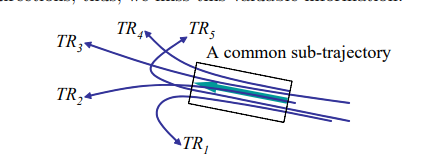

TRACLUS idea is to divide trajectory into a set of meaningfull line segments, then cluster them and by that catching possible common sub-trajectories (representative trajectory)

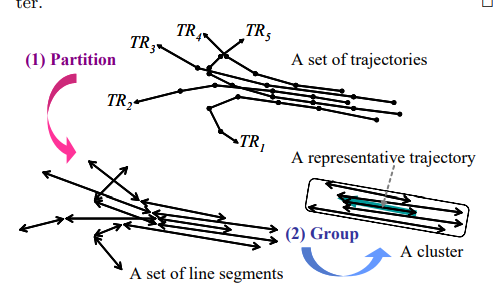

So far, I've found only one Python implementation made by Adriel Isaiah V. Amoguis (De La Salle University) as a thesis work. 

https://pypi.org/project/traclus-python/


# Imports

In [51]:
# %pip install traclus-python==1.0.1 cartopy

In [52]:
import zipfile
import os
import pandas as pd
import numpy as np
from typing import List, Tuple
from math import sqrt
from tqdm import tqdm
from traclus import traclus as tr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Ramer–Douglas–Peucker algorithm
Usual problem with trajectories is that there are a lot of datapoints in each trajectory and most of them are not significant. For example, if you move in a straight line for 10 seconds and sensor is making an observation each 0.01 second, you will end up with 1000 datapoints in straight line. And then you need to process all of them. You can't simply undersample them, because you simply don't know at what point object will make a significant turn.

So in order to reduce amount of data points I will use Ramer–Douglas–Peucker algorithm.

https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm

Simplified algorithm:
1. Find the farthest point from the straight line between the first and the last point
2. Check if distance between point and line is greater than given threshold (Epsilon parameter)
3. If distance is within threshold, simplify the point.
4. If distance is greater than threshold, than point must be kept as significant
5. Algorithm recursively calls itself to process whole curve




In [53]:
def calculate_distance(a: Tuple[float, float], b: Tuple[float, float]) -> float: 
    """
    Calculates Euclidean Distgance between two point
    Parameters:
        a (tuple) - list with two coordinates X and Y of first point
        b (tuple) - list with two coordinates X and Y of second point
    Returns:
        float: Euclidean Distance between two points
    """
    distance = sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    return distance


def calculate_point_line_distance(point: Tuple[float, float],
                                  start: Tuple[float, float],
                                  end: Tuple[float, float]) -> float:
    """
    Calculates the perpendicular (shortest) distance from a point to a line segment defined by two endpoints.
    Parameters:
        point (tuple): A tuple (x, y) representing the coordinates of the point.
        start (tuple): A tuple (x, y) representing the start of the line segment.
        end (tuple): A tuple (x, y) representing the end of the line segment.
    Returns:
        float: The perpendicular distance from the point to the infinite line defined
               by the start and end points. If start == end, returns the Euclidean
               distance from the point to the single point.
    """
    # If start and end points of the line are the same, it means that line is actually a point and we can calculate euclidean distance
    if start == end:
        distance = calculate_distance(point, start)
    else:
        # Numerator: area of the parallelogram
        n = abs(
            (end[0] - start[0]) * (start[1] - point[1]) -
            (start[0] - point[0]) * (end[1] - start[1])
        )
        # Denominator: length of the base (line segment)
        d = sqrt(
            (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2
        )
        distance = n / d
    return distance


def rdp(points: List[Tuple[float, float]], indices: List[int], epsilon: float) -> Tuple[List[Tuple[float, float]], List[int]]:
    """
    Simplify a polyline using the Ramer-Douglas-Peucker algorithm.

    This algorithm reduces the number of points in a curve while maintaining its
    general shape, by recursively removing points that deviate less than `epsilon`
    from a baseline segment.

    Parameters:
        points (List[Tuple[float, float]]): A list of (x, y) points representing the curve.
        indices (List[int]): The corresponding original indices of each point in the input list.
        epsilon (float): The maximum allowed deviation from the baseline segment.
                         Smaller values retain more detail.

    Returns:
        Tuple[List[Tuple[float, float]], List[int]]:
            - A list of simplified (x, y) points.
            - A list of their corresponding original indices from the input.
    """
    max_line_distance = 0.0
    index = 0

    # If length of the line is less than 3 points, there is nothing to simplify
    if len(points) < 3:
        return points, indices
    
    # Find the point farthest from the line between the first and last
    for i in range(1, len(points) - 1):
        line_distance = calculate_point_line_distance(points[i], points[0], points[-1])
        if line_distance > max_line_distance:
            index = i
            max_line_distance = line_distance

    # If the max distance is greater than epsilon, recursively simplify
    if max_line_distance >= epsilon:
        # Recursive simplification for both segments
        first_points, first_indices = rdp(points[:index + 1], indices[:index + 1], epsilon)
        second_points, second_indices = rdp(points[index:], indices[index:], epsilon)

        # Merge results, avoiding duplicate at the join point
        results = first_points[:-1] + second_points
        results_indices = first_indices[:-1] + second_indices
    else:
        # Only endpoints are significant since the trajectory is simple enough
        results = [points[0], points[-1]]
        results_indices = [indices[0], indices[-1]]

    return results, results_indices

In [54]:
def extract_and_simplify(df: pd.DataFrame, epsilon: float, min_trajectory_len: int) -> Tuple[List[Tuple[float, float]], List[int]]:
    """
    Groups and extracts trajectories from Pandas DataFrame, then simplifies trajectories using rdp function
    Parmeters:
        df (pd.DataFrame) - dataset with columns id, timestamp, pos_x and pos_y
        epsilon (float) - threshold fro rdp function. The smaller it is the more details is preserved
    Returns:
        Tuple[List[Tuple[float, float]], List[int]]:
            - A list of simplified (x, y) points.
            - A list of their corresponding original IDs.
        """
    # Store simplified trajectories and IDs of the objects
    trajectories = []
    object_ids = []

    # Sort by object ID and timestamp
    df_sorted = df.sort_values(['id', 't'])
    grouped = df_sorted.groupby('id')

    # Iterate with tqdm progress bar
    for object_id, group in tqdm(grouped, desc="Simplifying trajectories"):
        points = list(zip(group['longitude'], group['latitude']))
        if len(points) < min_trajectory_len:
            continue
        indices = group.index.tolist()
        simplified, _ = rdp(points, indices, epsilon)
        trajectories.append(simplified)
        object_ids.append(object_id)

    return trajectories, object_ids

# Import data

CSV file is too big to be in github, so I will include .zip archive and automatic unpacking for convinience 

In [55]:
zip_path = "128_fishing_trajs.zip"      # Path to your zip file

if os.path.exists(zip_path):
    print(f"Found archive: {zip_path}")
    if not os.path.exists("128_fishing_trajs.csv"):
        print("Unpacking...")
        # Unzip the archive
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall()
        print("Finished")
    else:
        print("Seems to be already extracted")
    

Found archive: 128_fishing_trajs.zip
Seems to be already extracted


In [56]:

df = pd.read_csv("128_fishing_trajs.csv")
df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

I will work only with latitude and longitude. Timestamp also might be usefull. And I'll need to preserve ID as well. Other features might be discarded

In [ ]:
df = df[["id", "t", "longitude", "latitude"]]
df

,id,t,longitude,latitude
0,211477000-2,2021-11-14 15:00:10,12.310170,56.127777
1,211477000-2,2021-11-14 15:00:13,12.310137,56.127788
2,211477000-2,2021-11-14 15:00:16,12.310103,56.127800
3,211477000-2,2021-11-14 15:00:18,12.310067,56.127815
4,211477000-2,2021-11-14 15:00:22,12.310025,56.127830
...,...,...,...,...
1026274,235008380-3,2021-11-20 23:59:34,7.193117,56.044555
1026275,235008380-3,2021-11-20 23:59:40,7.193007,56.044565
1026276,235008380-3,2021-11-20 23:59:46,7.192868,56.044572
1026277,235008380-3,2021-11-20 23:59:51,7.192725,56.044572


# Find optimal distance treshold
By testing with diferent epsilon parameters, I've found out that values greater than 0.005 don't reduce amount of datapoints that much anymore, but the accuracy starts to drop. So I guess, values around 0.005-0.007 are somewhat optimal.

We reduce amount of data from thousands of point to dozens and also we keep the general form of trajectory accurate.

Simplifying trajectories: 100%|██████████| 1/1 [00:00<00:00, 40.09it/s]


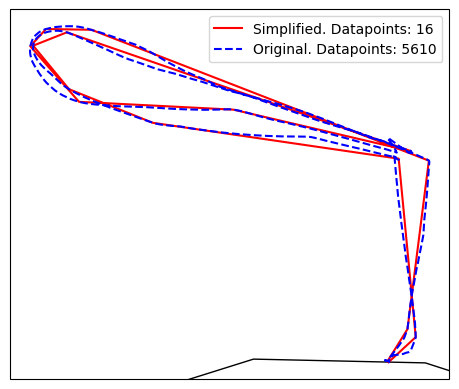

Simplifying trajectories: 100%|██████████| 1/1 [00:00<00:00, 60.62it/s]


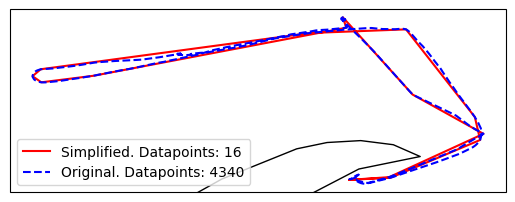

Simplifying trajectories: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


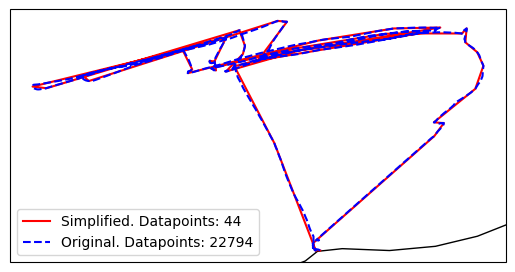

Simplifying trajectories: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


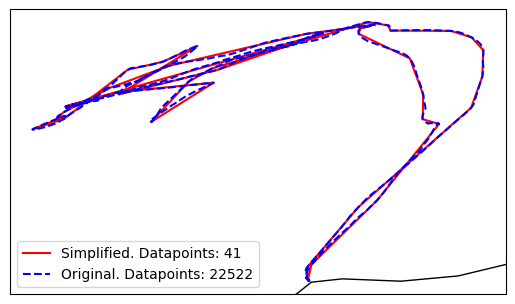

Simplifying trajectories: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


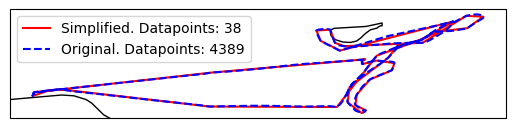

In [ ]:
# Pick some random objects to test
test_ids = ["211477000-2", '219007027-2', '219026172-2', '219796000-2', '220335000-2']

for id in test_ids:
    sample = df[df.id == id]

    # Simplify trajectory
    simplified_trajs, _ = extract_and_simplify(sample, epsilon=0.006, min_trajectory_len=25)
    trajectory = simplified_trajs[0]
    # Separate longitudes and latitudes
    lons, lats = zip(*trajectory)

    # Plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.plot(lons, lats, color='red', transform=ccrs.PlateCarree(), label=f"Simplified. Datapoints: {len(simplified_trajs[0])}")
    ax.plot(sample["longitude"], sample["latitude"], color='blue', linestyle="--", transform=ccrs.PlateCarree(), label=f"Original. Datapoints: {len(sample)}")
    ax.legend()
    plt.show()

# Reduce all trajectories

In [ ]:
simplified_trajs, original_ids = extract_and_simplify(df, epsilon=0.006, min_trajectory_len=500)

Simplifying trajectories: 100%|██████████| 123/123 [00:05<00:00, 23.31it/s]


In [ ]:
# Convert to acceptable by traclus format
simplified_trajs = [np.array(traj) for traj in simplified_trajs]

# Proceed to clustering

In [ ]:
# Run the TRACLUS Algorithm
partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories = tr.traclus(simplified_trajs)

## Plot all trajectories

Area that we are working with is North Sea, around Denmark

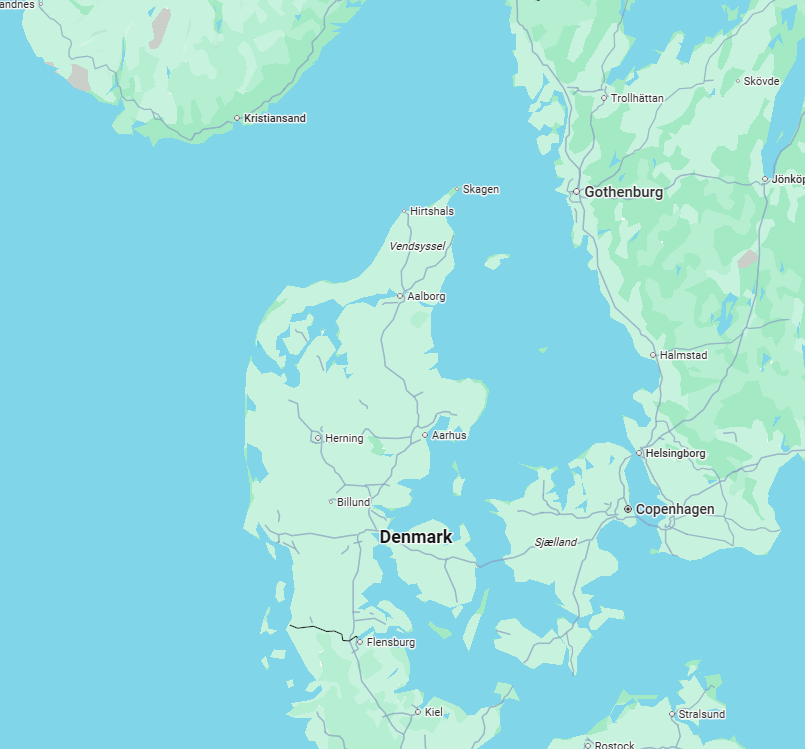

In [ ]:
def plot_trajectories(trajectory_list: list, title: str, legend: bool=False) -> None:
    # Initialize figure and axis
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Parse minimal and maximum coordinates and set right "zoom"
    lon_min = df["longitude"].min() - 1
    lon_max = df["longitude"].max() + 1
    lat_min = df["latitude"].min() - 1
    lat_max = df["latitude"].max() + 1
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add coastlines and background image
    # Image resolution scales really bad 
    ax.coastlines()
    ax.stock_img()

    for i, traj in enumerate(trajectory_list):
    # Split into longitude and latitude
        lons, lats = traj[:, 0], traj[:, 1]

        # Plot each trajectory with a unique label
        ax.plot(lons, lats, transform=ccrs.PlateCarree(), label=f"Trajectory {i + 1}")
    if legend:
        ax.legend()
    ax.set_title(title)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.show()

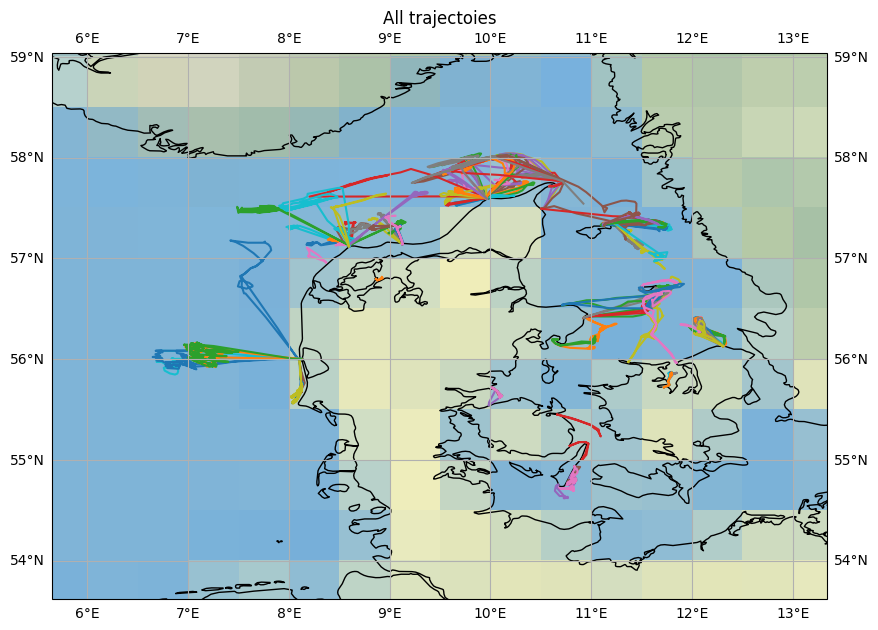

In [ ]:
plot_trajectories(simplified_trajs, title="All trajectoies")

We got 22 clusters after perfoming TRACLUS clustering. For some reason first cluster is a real mess which includes everything, so I will exclude it.

## Plot all clusters

In [63]:
# Create an array of colors for the clusters
colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)-1))

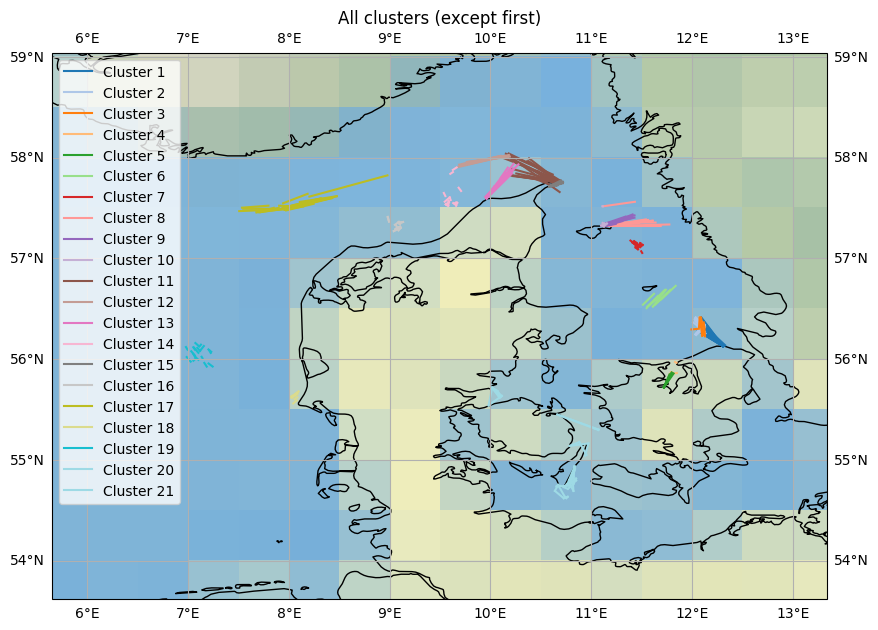

In [64]:
# Initialize figure and axis
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Parse minimal and maximum coordinates and set right "zoom"
lon_min = df["longitude"].min() - 1
lon_max = df["longitude"].max() + 1
lat_min = df["latitude"].min() - 1
lat_max = df["latitude"].max() + 1
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# Add coastlines and background image
# Image resolution scales really bad 
ax.coastlines()
ax.stock_img()

for e, cluster in enumerate(clusters[1:], start=1):
    color = colors[e-1]  # pick one color for this cluster
    
    for i, traj in enumerate(cluster):
        lons, lats = traj[:, 0], traj[:, 1]

        if i == 0:
            ax.plot(lons, lats, color=color, transform=ccrs.PlateCarree(), label=f"Cluster {e}")
        else:
            ax.plot(lons, lats, color=color, transform=ccrs.PlateCarree())

ax.legend()
ax.set_title("All clusters (except first)")
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

## Compare to representative trajectories

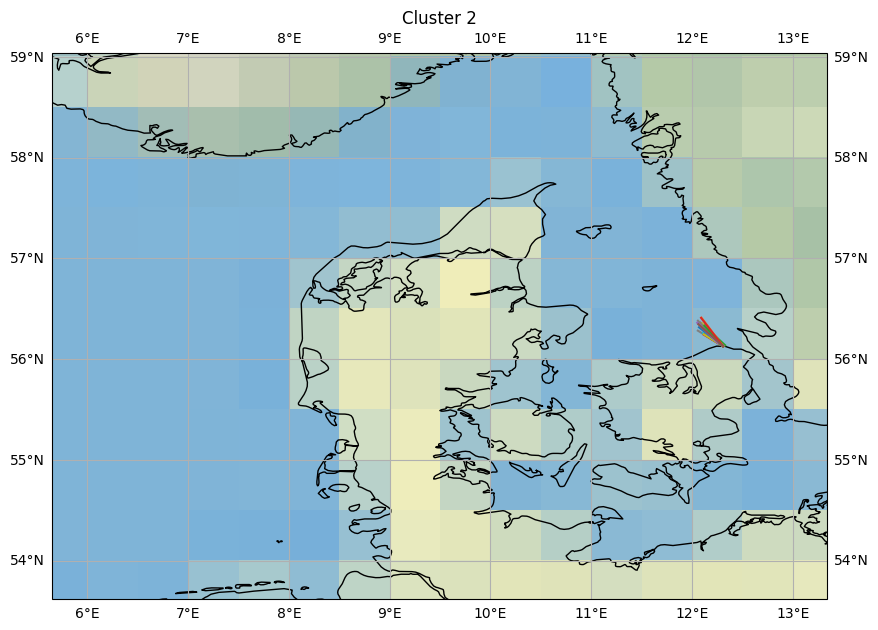

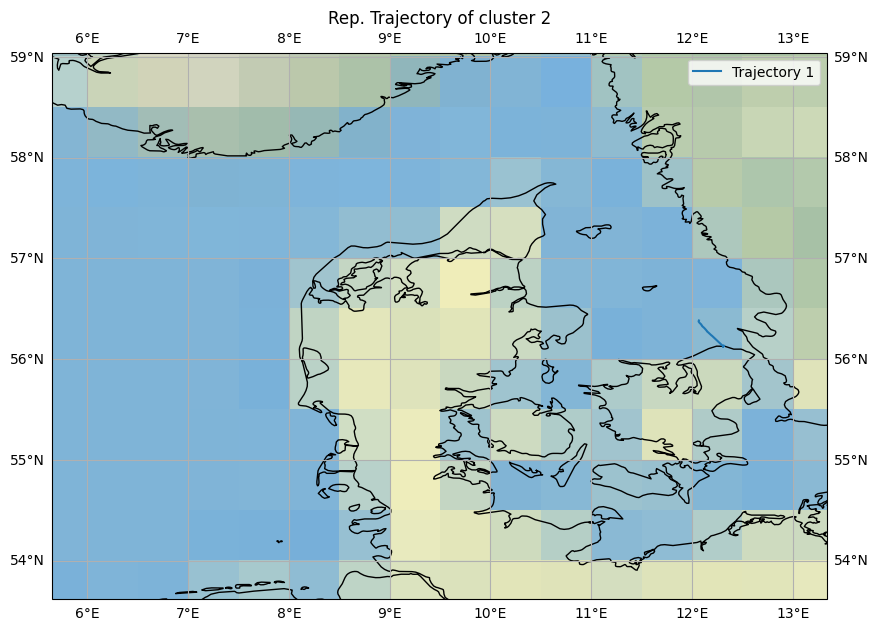

In [76]:
plot_trajectories(clusters[1], title="Cluster 2")
# Need to wrap element with list to imitate same structure for plot_trajectories function
plot_trajectories([representative_trajectories[1]], title="Rep. Trajectory of cluster 2", legend=True)

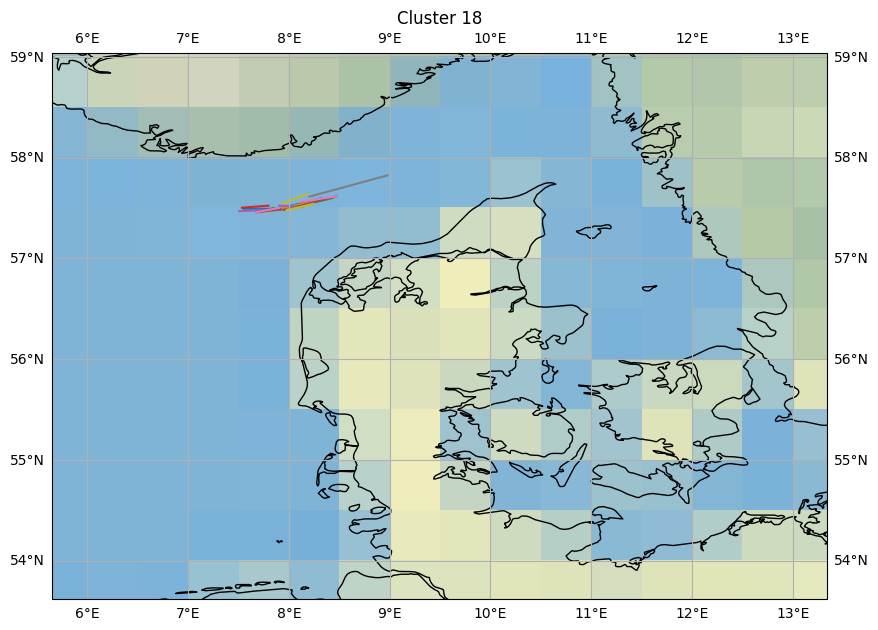

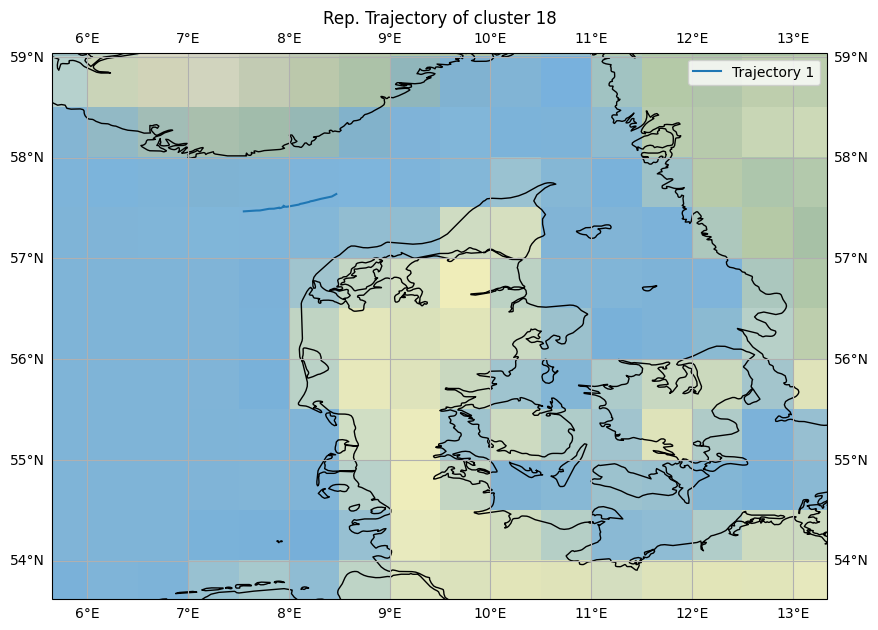

In [75]:
plot_trajectories(clusters[17], title="Cluster 18")
# Need to wrap element with list to imitate same structure for plot_trajectories function
plot_trajectories([representative_trajectories[17]], title="Rep. Trajectory of cluster 18", legend=True)

# Conclusion

So, instead of clusterizing whole trajectories, we were able to find common sub trajectories by separating whole path into segments.

 I believe there are a lot of use cases for such technology, such as smart cities, building, traffic regulating, or studying movement of animals, people, natural disasters (hurricanes). 

Even with this dataset we could proceed further and find out what these clusters are. In original data is "label" feature which tells about was ship fishing, sailing etc. We could search for common fishing paths and places as well as distinguish them from sea routes.

Also, as clustering itself under the hood is based on DBSCAN, it is possible to play around the epsilon and minimal amount of samples. By default they are 1 and 10 if I'm not mistaken, and 1 whole degree in latitude and longitude is quite a lot. As well as 10 samples is like more or less 10% of the whole dataset. So I think it is possible to detect even smaller clusters and improve the results.